In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from torch.utils.data.sampler import WeightedRandomSampler

In [14]:
# TO SPLIT THE DATA EVENLY
def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []
    
    # Collect real videos
    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)
        
    
    # Collect fake videos
    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]
    
    #REMOVE AFTER TESTING
    # real_videos = real_videos[:500]
    fake_videos = fake_videos[:2000]
    
    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")
    
    # Split each class separately
    splits_dict = {split: [] for split in ['train', 'val', 'test']}
    
    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)
        
        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)
    
    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)
    
    return splits_dict, class_counts

In [4]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders('/kaggle/input/celeb-df-v2','/kaggle/working/',dim=224,batch_size=12,sequence_length=16)

Real videos: 890, Fake videos: 2000


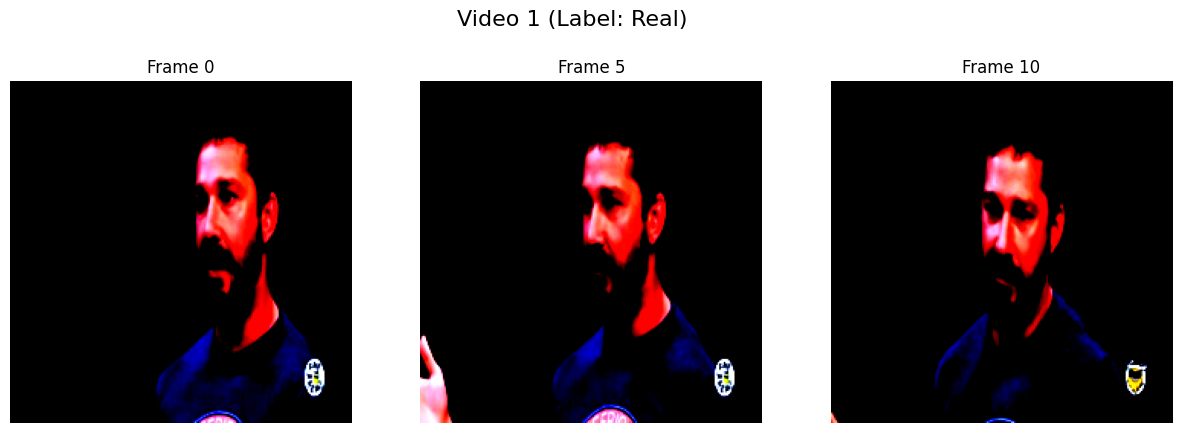

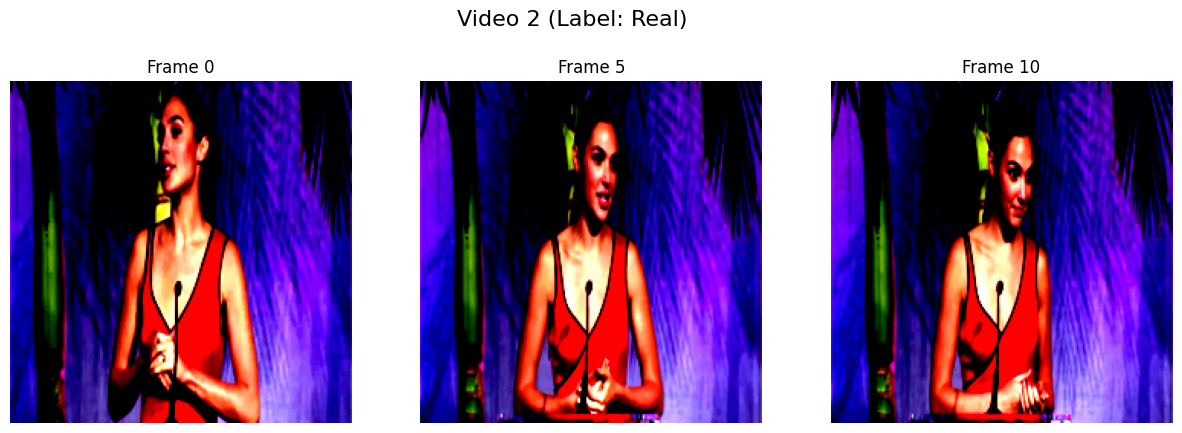

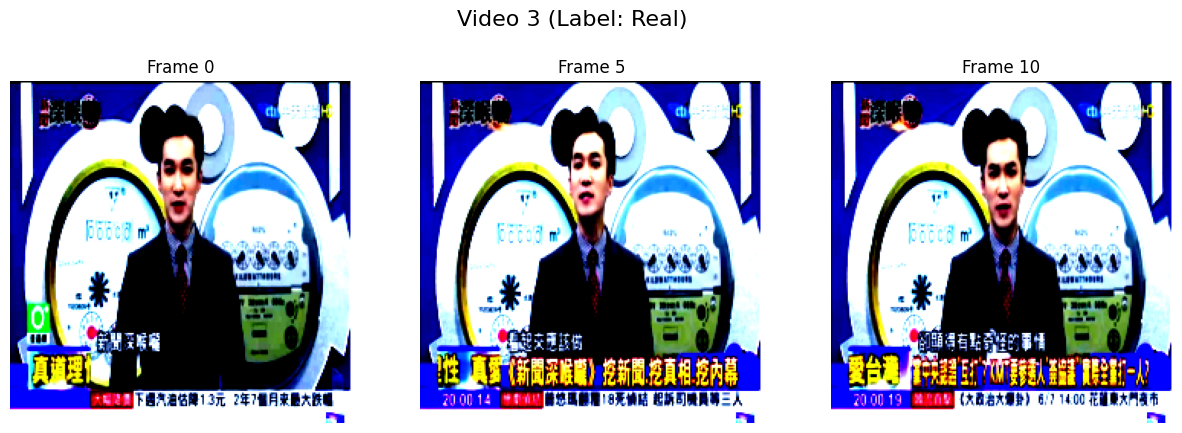

In [5]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=2, num_frames=5):
    """
    Visualizes frames from videos in a batch.
    Args:
        data_loader: DataLoader object containing the video dataset.
        num_videos: Number of videos to visualize from the batch.
        num_frames: Number of frames to visualize per video.
    """
    # Fetch one batch of data
    batch = next(iter(data_loader))
    videos, labels = batch  # videos: [batch_size, sequence_length, C, H, W], labels: [batch_size]

    videos = videos[:num_videos]  # Take the first few videos
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        # Convert video tensor to numpy array and move channel to the last dimension
        video = video.permute(0, 2, 3, 1).numpy()  # Shape: [sequence_length, H, W, C]

        # Plot frames
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)
        
        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))  # Select evenly spaced frames
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")
        
        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=3)

In [6]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
# from pytorchvideo.models.hub import mvit_base_16x4
from torchvision.models.video import mvit_v2_s , MViT_V2_S_Weights
import wandb
import torch.nn.functional as F

class MViTVideoClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()

        # Load pre-trained MViT model
        self.backbone = mvit_v2_s(weights="DEFAULT")
        
        # Freeze the backbone parameters
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
        
        # blocks_to_unfreeze = self.backbone.blocks[-2:]
       
        # for block in blocks_to_unfreeze:
        #    for param in block.parameters():
        #        param.requires_grad = True
               
        # Modify the final classification head
        features = self.backbone.head[1].in_features
        self.backbone.head = nn.Sequential(
            nn.Linear(features, features // 2),
            nn.LayerNorm(features // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(features // 2, num_classes),
            nn.Sigmoid() if num_classes == 1 else nn.Identity()
        )
        

    def forward(self, x):
        # Forward pass through the MViT backbone
        # print("Input shape: ",x.shape)
        x_permuted = x.permute(0, 2, 1, 3, 4)
        # print("After Trans: ", x_permuted.shape)
        x = self.backbone(x_permuted)
        # print("Output shape: ", x.shape)
        outputs = x.squeeze()
        if isinstance(outputs, torch.Tensor) and outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)
        return outputs

In [7]:
class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=5,
        device='cuda',
        use_wandb=False
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.metrics = []
        
        # Loss function with class weighting
        # pos_weight = self._calculate_pos_weight()
        # self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.criterion = nn.BCEWithLogitsLoss()
        
        # Optimizer and scheduler
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )
        
        if use_wandb:
            self._init_wandb()

    def _calculate_pos_weight(self):
        total_pos = sum(1 for _, label in self.train_loader.dataset if label == 1)
        total_neg = len(self.train_loader.dataset) - total_pos
        return torch.tensor([total_neg / total_pos]).to(self.device)

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": "resnet50",
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []
        
        for batch_idx, (videos, labels) in enumerate(self.train_loader):
            videos, labels = videos.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(videos)
            # print(outputs.shape)
            # print(labels.shape)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            
            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())
            
            
        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print("Train Epoch Loss: ",metrics['loss'])
        return metrics

    def validate(self,mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader
        if mode == 'test':
            loader = self.test_loader
        with torch.no_grad():
            for videos, labels in loader:
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        # REMOVE
        # print("Validation:")
        # print((np.array(predictions) > 0.5).astype(int))
        # print(targets)
        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print("Validation Epoch Loss: ",metrics['loss'])
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)
        
        # Convert probabilities to binary predictions
        binary_preds = (predictions > 0.5).astype(int)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary'
        )
        auc = roc_auc_score(targets, predictions)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()
            
            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }
            
            self._log_metrics(metrics)
        print("[Running on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)
    
    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        # WRITE HERE
        self.metrics.append(metrics)
        # Weight and Biases
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v 
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [8]:
def train_model(train_loader, val_loader,test_loader, config=None):

    if config is None:
        config = {
            'learning_rate': 0.0001,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }
    
    model = MViTVideoClassifier()
    # print(model)
    #Utilize Parallel computing
    model = torch.nn.DataParallel(model)
    
    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader= test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb']
    )
    
    trainer.train()
    return model , trainer.metrics

In [9]:
 model , metrics = train_model(train_loader, val_loader,test_loader)

Downloading: "https://download.pytorch.org/models/mvit_v2_s-ae3be167.pth" to /root/.cache/torch/hub/checkpoints/mvit_v2_s-ae3be167.pth
100%|██████████| 132M/132M [00:00<00:00, 214MB/s] 


Train Epoch Loss:  0.6927543730425412


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Epoch Loss:  0.6891832609434385
Epoch 1/10
Train - precision: 0.6349 | recall: 0.0801 | f1: 0.1422 | auc: 0.5456 | loss: 0.6928
Val - precision: 0.0000 | recall: 0.0000 | f1: 0.0000 | auc: 0.6965 | loss: 0.6892
Train Epoch Loss:  0.680090738118753
Validation Epoch Loss:  0.6921162814707369
Epoch 2/10
Train - precision: 0.7771 | recall: 0.1256 | f1: 0.2163 | auc: 0.5739 | loss: 0.6801
Val - precision: 0.0000 | recall: 0.0000 | f1: 0.0000 | auc: 0.6835 | loss: 0.6921


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch Loss:  0.6911998606292453
Validation Epoch Loss:  0.5653500242813213
Epoch 3/10
Train - precision: 0.7059 | recall: 0.0241 | f1: 0.0466 | auc: 0.5362 | loss: 0.6912
Val - precision: 0.7583 | recall: 0.9100 | f1: 0.8273 | auc: 0.7694 | loss: 0.5654
Train Epoch Loss:  0.6439538934879755
Validation Epoch Loss:  0.5295214685233863
Epoch 4/10
Train - precision: 0.7371 | recall: 0.6160 | f1: 0.6711 | auc: 0.7684 | loss: 0.6440
Val - precision: 0.9079 | recall: 0.7233 | f1: 0.8052 | auc: 0.8586 | loss: 0.5295
Train Epoch Loss:  0.6001983369595906
Validation Epoch Loss:  0.5365441932871535
Epoch 5/10
Train - precision: 0.8548 | recall: 0.7002 | f1: 0.7698 | auc: 0.8442 | loss: 0.6002
Val - precision: 0.9453 | recall: 0.6333 | f1: 0.7585 | auc: 0.8661 | loss: 0.5365
Train Epoch Loss:  0.5893393901325542
Validation Epoch Loss:  0.5063687852911047
Epoch 6/10
Train - precision: 0.8416 | recall: 0.7915 | f1: 0.8158 | auc: 0.8711 | loss: 0.5893
Val - precision: 0.9127 | recall: 0.8367 | 

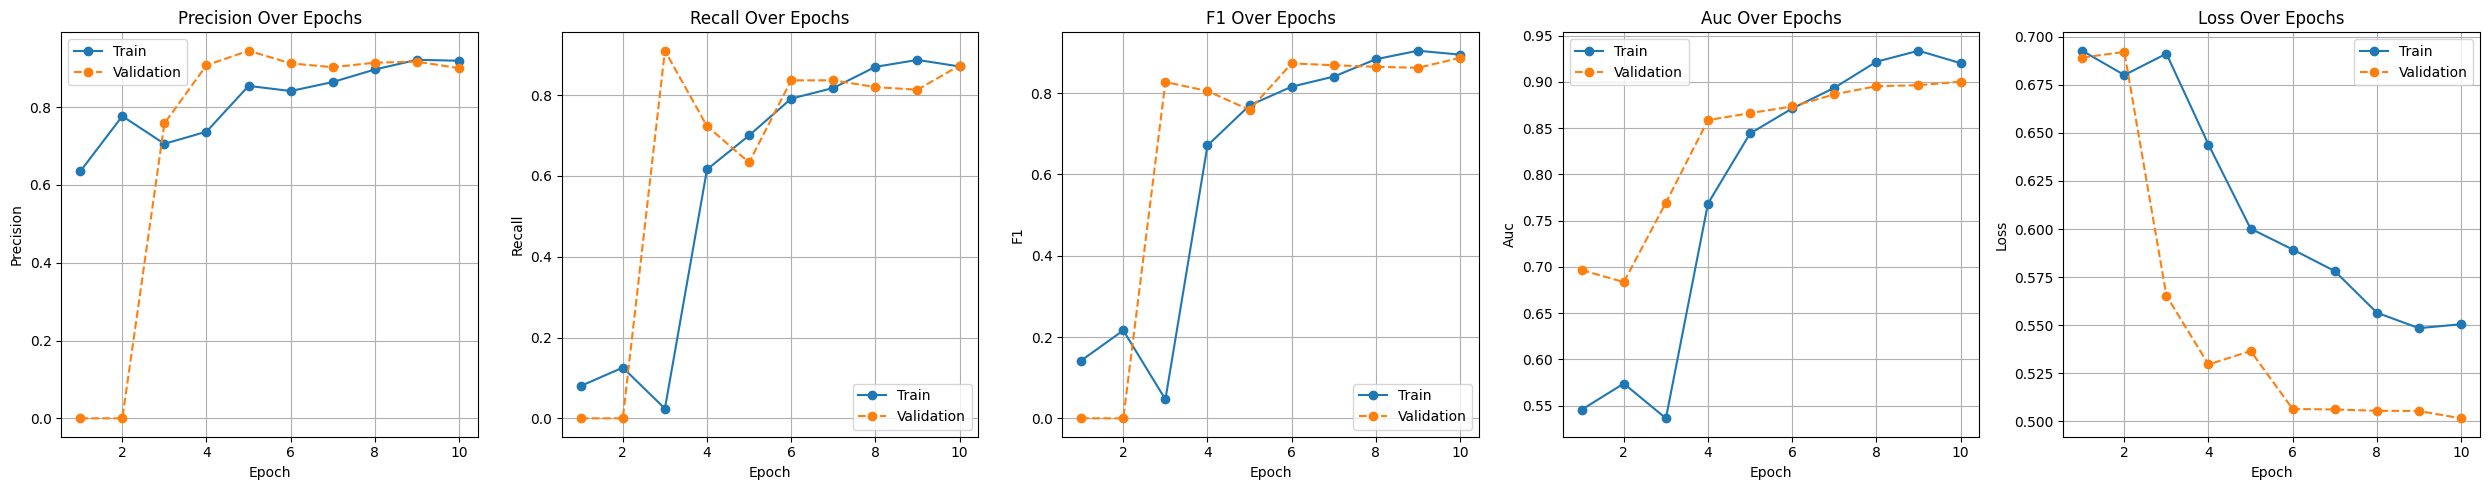

In [10]:
import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """
    Visualizes training and validation metrics over epochs.

    Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    # Extract epochs, training, and validation metrics
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}
    
    # List of metric names
    metric_names = list(train_metrics.keys())
    
    # Set up the plots
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot
    
    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example Usage

visualize_metrics(metrics)

In [11]:
import torch
import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_curve
)
import matplotlib.pyplot as plt


class ModelEvaluator:
    def __init__(self, model, test_loader, device="cuda", class_names=None):
        """
        Initialize the evaluator with the model and test data loader.
        Args:
            model (torch.nn.Module): The trained model to evaluate.
            test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
            device (str): The device to use for evaluation (default: "cuda").
            class_names (list): List of class names for the confusion matrix.
        """
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names or ["Class 0", "Class 1"]
        self.predictions = []
        self.targets = []
        self.samples = []
        self.threshold = 0.59

    def evaluate(self):
        """Evaluate the model on the test dataset."""
        self.model.eval()
        with torch.no_grad():
            for videos, labels in self.test_loader:
                videos, labels = videos.to(self.device), labels.to(self.device)
                outputs = self.model(videos)
                probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
                self.predictions.extend(probs)
                self.targets.extend(labels.cpu().numpy())
                self.samples.extend(videos.cpu().numpy())
        
        self.predictions = np.array(self.predictions).squeeze()
        self.targets = np.array(self.targets).squeeze()
        self.samples = np.array(self.samples)
        return self._calculate_metrics()

    def _calculate_metrics(self):
        """Calculates precision, recall, F1, AUC, and accuracy."""
        binary_preds = (self.predictions > self.threshold).astype(int)

        # Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            self.targets, binary_preds, average="binary"
        )
        auc = roc_auc_score(self.targets, self.predictions)
        acc = accuracy_score(self.targets, binary_preds)

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "accuracy": acc,
        }

    def plot_confusion_matrix(self):
        """Plots the confusion matrix."""
        binary_preds = (self.predictions > self.threshold).astype(int)
        cm = confusion_matrix(self.targets, binary_preds, labels=range(len(self.class_names)))

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_roc_curve(self):
        """Plots the ROC curve and AUC."""
        fpr, tpr, _ = roc_curve(self.targets, self.predictions)

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {self._calculate_metrics()["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_examples(self, num_examples=5):
        """
        Plots examples of misclassifications and correct classifications.
        Args:
            num_examples (int): Number of examples to display for each case.
        """
        binary_preds = (self.predictions > self.threshold).astype(int)
        misclassified_indices = np.where(binary_preds != self.targets)[0]
        correctly_classified_indices = np.where(binary_preds == self.targets)[0]

        def plot_samples(indices, title, num_examples):
            indices = np.random.choice(indices, size=min(len(indices), num_examples), replace=False)
            fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
            fig.suptitle(title, fontsize=16)
            if len(indices) == 1:  # Handle single subplot case
                axes = [axes]
            for ax, idx in zip(axes, indices):
                sample = self.samples[idx]
                label = self.targets[idx]
                pred = binary_preds[idx]

                # Show a single frame from the video for simplicity
                ax.imshow(sample[0, 0], cmap="gray")  # Assuming single-channel grayscale images
                ax.set_title(f"True: {self.class_names[int(label)]}\nPred: {self.class_names[int(pred)]}")
                ax.axis("off")
            plt.show()

        if len(misclassified_indices) > 0:
            plot_samples(misclassified_indices, "Misclassified Examples", num_examples)
        else:
            print("No misclassified examples found.")

        if len(correctly_classified_indices) > 0:
            plot_samples(correctly_classified_indices, "Correctly Classified Examples", num_examples)
        else:
            print("No correctly classified examples found.")

    def display_metrics(self):
        """Calculate and display metrics, confusion matrix, and examples."""
        print("Evaluating Model...")
        metrics = self.evaluate()

        print("\nMetrics:")
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        print("\nPlotting Confusion Matrix...")
        self.plot_confusion_matrix()

        print("\nDisplaying Examples...")
        self.plot_examples()

        print("\nPlotting ROC Curve...")
        self.plot_roc_curve()

In [12]:
evaluator = ModelEvaluator(model,test_loader,class_names=['Real','Fake'])

Evaluating Model...

Metrics:
Precision: 0.8333
Recall: 0.8500
F1: 0.8416
Auc: 0.8313
Accuracy: 0.7788

Plotting Confusion Matrix...


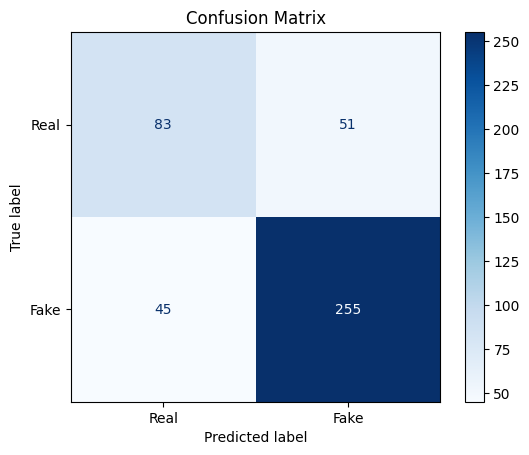


Displaying Examples...


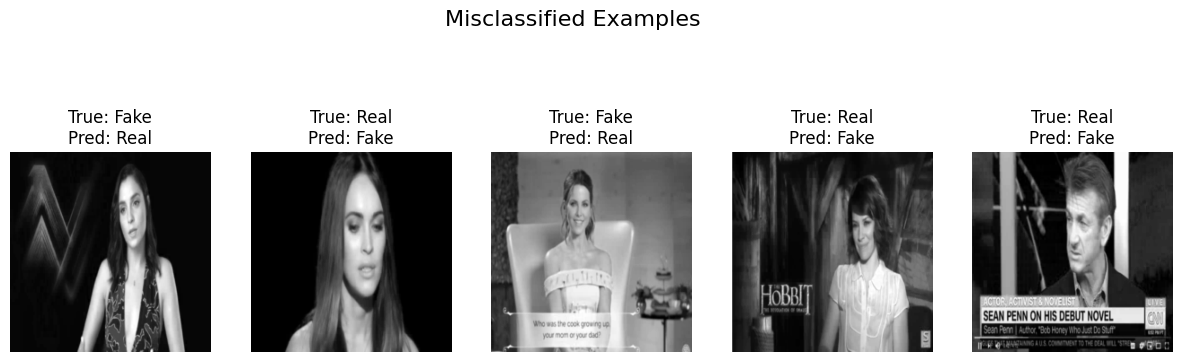

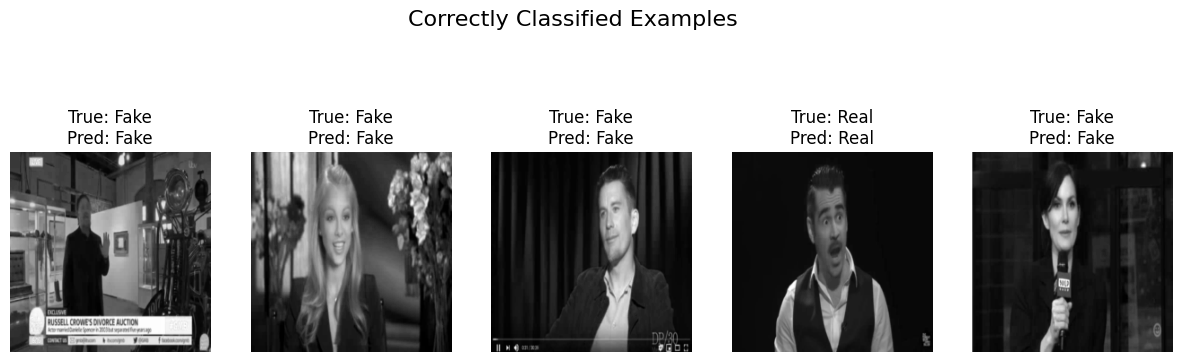


Plotting ROC Curve...


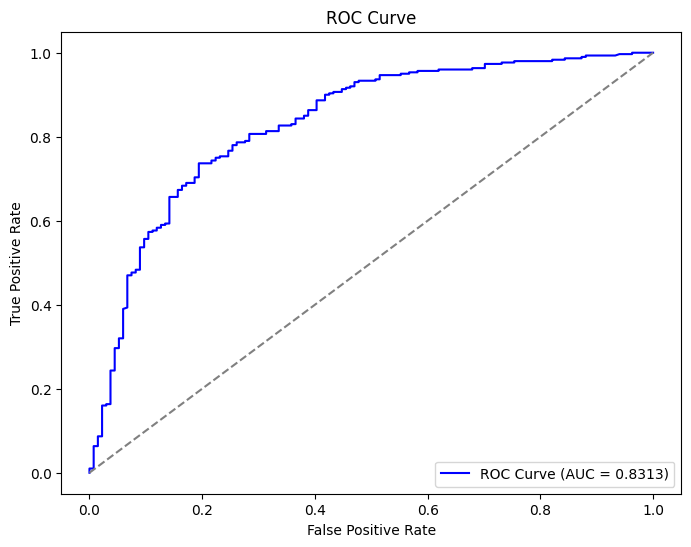

In [13]:
evaluator.display_metrics()